In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as opt
from __future__ import division

plt.style.use('ggplot')
%matplotlib inline

In [6]:
TB = pd.read_excel('./Tbill10yr.xls',skiprows=14,convert_float=True,names=['Rate'],index_col=0)
TB.head()

,Rate
DATE,
1953-04-01,2.83
1953-05-01,3.05
1953-06-01,3.11
1953-07-01,2.93
1953-08-01,2.95


In [7]:
TB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 1953-04-01 to 2014-02-01
Data columns (total 1 columns):
Rate    731 non-null float64
dtypes: float64(1)
memory usage: 11.4 KB


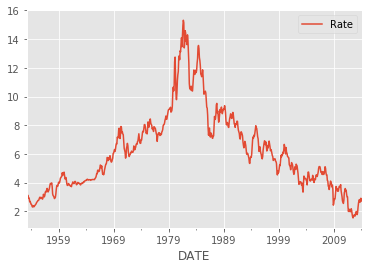

In [8]:
TB.plot()

### OLS

In [62]:
def OLS(Y, X, const=True):
    Y = np.array(Y)
    X = np.c_[np.ones(np.shape(Y)),np.array(X)] if const else np.array(X)
    
    cov = np.dot(np.transpose(X),Y)
    var = np.dot(np.transpose(X),X)

    b = np.dot(np.linalg.inv(var), cov) if np.shape(var) != () else cov / var

    return b if b.shape!=(1,1) else float(b)

def AR_preprocess(TS, ar_lags=1):
    
    df = pd.DataFrame({'y': TS})
    for i in range(1, ar_lags + 1):
        df['x_t' + str(i)] = df.y.shift(i)
        
    df.dropna(inplace=True)
        
    return df

In [99]:
def LogLikelihood(df, c, phi, v):
    
    v = abs(v)
    e = df.y - c - df.iloc[:,1:].dot(np.array(phi))
    T = df.shape[0]
    
    sse = e.T.dot(e)
    
    return float(-T / 2 * (np.log(2 * np.pi * v)) - sse / (2 * v))

### AR(1)

In [107]:
df = AR_preprocess(TB.values.ravel(),1)

y, X = df.y, df.values[:,1:] #sm.add_constant(df.values[:,1:])
beta = OLS(y, X)
beta

array([ 0.02911663,  0.99520032])

In [108]:
ar1_min_object = lambda p: - LogLikelihood(df, p[0], np.array([p[1]]), p[2])
res = opt.minimize(ar1_min_object, [0, 1, 1])

my_theta = res.x
print 'c: %.4f\nphi: %.4f\nsigma^2: %.4f'% tuple(my_theta)
my_theta[-1] ** 0.5

c: 0.0291
phi: 0.9952
sigma^2: 0.0747


0.27337530395171644

In [113]:
arma_model = sm.tsa.ARMA(TB.values, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='c')
ests.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:                     ARMA(1, 0)   Log Likelihood                 -91.453
Method:                       css-mle   S.D. of innovations              0.273
Date:                Sun, 30 Apr 2017   AIC                            188.906
Time:                        22:21:34   BIC                            202.689
Sample:                             0   HQIC                           194.224
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.8613      1.815      2.678      0.008         1.303     8.419
ar.L1.y        0.9954      0.003    321.138      0.000         0.989     1.001
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0046           +0.0000j            1.0046            0.0000
-----------------------------------------------------------------------------
"""

### AR(2)

In [110]:
df = AR_preprocess(TB.values.ravel(), 2)

y, X = df.y, df.values[:,1:] #sm.add_constant(df.values[:,1:])
beta = OLS(y, X)
beta

array([ 0.03729302,  1.30381248, -0.30999947])

In [111]:
ar2_min_object = lambda p: - LogLikelihood(df, p[0], np.array([p[1], p[2]]), p[3])
res = opt.minimize(ar2_min_object, [0, 1, 1, 1])
my_theta = res.x
print 'c: %.4f\nphi_1: %.4f\nphi_2: %.4f\nsigma^2: %.4f'% tuple(my_theta)
my_theta[-1] ** 0.5

c: 0.0373
phi_1: 1.3038
phi_2: -0.3100
sigma^2: 0.0676


0.25998197516366006

In [114]:
arma_model = sm.tsa.ARMA(TB.values, order=(2,0))

ests = arma_model.fit(maxiter=500, trend='c')
ests.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:                     ARMA(2, 0)   Log Likelihood                 -54.699
Method:                       css-mle   S.D. of innovations              0.260
Date:                Sun, 30 Apr 2017   AIC                            117.397
Time:                        22:21:41   BIC                            135.775
Sample:                             0   HQIC                           124.487
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2881      1.431      3.694      0.000         2.483     8.094
ar.L1.y        1.3035      0.035     37.093      0.000         1.235     1.372
ar.L2.y       -0.3095      0.035     -8.796      0.000        -0.378    -0.241
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0088           +0.0000j            1.0088            0.0000
AR.2            3.2028           +0.0000j            3.2028            0.0000
-----------------------------------------------------------------------------
"""

In [54]:
def homo_se_beta(y, X, beta, const=True):
    
    X = np.c_[np.ones(len(y)),X] if const else X
    e = y - X.dot(beta)
    
    mse = (e.T.dot(e)/len(e))[0]
    V = np.linalg.inv(X.T.dot(X))

    return np.sqrt(V.diagonal() * mse)

In [14]:
def heter_se_beta(y, X, beta, const=True):
    
    X = np.c_[np.ones(len(y)),X] if const else X
    e = y - X.dot(beta)
    
    V = np.linalg.inv(X.T.dot(X))
    
    out_product = lambda i: np.array(map(lambda ele: ele * i, i))
    U = reduce(lambda a, b: a + b, [out_product(i)*(j*j) for i,j in zip(X,e)])
    
    return np.sqrt(np.dot(V.dot(U), V).diagonal())

In [15]:
def R_squares(y, X, beta, const=True):
    
    X = np.c_[np.ones(len(y)),X] if const else X
    e = y - X.dot(beta)
    n = len(y)

    sse = (e.T.dot(e))
    sst = (y.T.dot(y)) - n * np.mean(y) **2
    
    return {'R_square': (1 - sse/sst), 'Adj_R_square': (1 - (sse/sst)*(n - 1)/(n-len(beta)-1))}

In [16]:
def sd_e(y, X, beta, const=True):
    
    X = np.c_[np.ones(len(y)),X] if const else X
    e = y - X.dot(beta)
    n = len(y)
    
    return np.sqrt((e.T.dot(e) - n * np.mean(e) ** 2)/(n - 1))

In [17]:
def Likelihood(y, X, beta, const=True):
    X = np.c_[np.ones(len(y)),X] if const else X
    e = y - X.dot(beta)
    n = len(y)
    
    sse = e.T.dot(e) / n
    
    return float(-n * 0.5 * (np.log(2 * np.pi) + 1 + np.log(sse)))

def AIC(y, X, beta, const=True):
    L = Likelihood(y, X, beta, const=True)
    n = len(y)
    k = X.shape[1] + (1 if const else 0)
    aic = 2*(-L+k)
    
    return aic, aic/n

def BIC(y, X, beta, const=True):
    L = Likelihood(y, X, beta, const=True)
    n = len(y)
    k = X.shape[1] + (1 if const else 0)
    print k, n
    bic = (k*np.log(n)-2*L)
    
    return bic, bic/n

### AR(1)

statsmodels

In [18]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 4.093e+04
Date:                Sat, 22 Apr 2017   Prob (F-statistic):               0.00
Time:                        01:00:28   Log-Likelihood:                -52.339
No. Observations:                 729   AIC:                             110.7
Df Residuals:                     726   BIC:                             124.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0373      0.023      1.596      0.111        -0.009     0.083
x1             1.3038      0.035     36.956      0.000         1.235     1.373
x2            -0.3100      0.035     -8.787      0.000        -0.379    -0.241
==============================================================================
Omnibus:                      103.906   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1131.532
Skew:                          -0.134   Prob(JB):                    1.95e-246
Kurtosis:                       9.098   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.521e+04
Date:                Sat, 22 Apr 2017   Prob (F-statistic):               0.00
Time:                        01:00:28   Log-Likelihood:                -52.339
No. Observations:                 729   AIC:                             110.7
Df Residuals:                     726   BIC:                             124.5
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0373      0.031      1.188      0.235        -0.024     0.099
x1             1.3038      0.055     23.655      0.000         1.196     1.412
x2            -0.3100      0.056     -5.505      0.000        -0.420    -0.200
==============================================================================
Omnibus:                      103.906   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1131.532
Skew:                          -0.134   Prob(JB):                    1.95e-246
Kurtosis:                       9.098   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### AR(2)

self-implementation

### AR(2)

statsmodels

In [20]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 4.093e+04
Date:                Sat, 22 Apr 2017   Prob (F-statistic):               0.00
Time:                        01:00:28   Log-Likelihood:                -52.339
No. Observations:                 729   AIC:                             110.7
Df Residuals:                     726   BIC:                             124.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0373      0.023      1.596      0.111        -0.009     0.083
x1             1.3038      0.035     36.956      0.000         1.235     1.373
x2            -0.3100      0.035     -8.787      0.000        -0.379    -0.241
==============================================================================
Omnibus:                      103.906   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1131.532
Skew:                          -0.134   Prob(JB):                    1.95e-246
Kurtosis:                       9.098   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.521e+04
Date:                Sat, 22 Apr 2017   Prob (F-statistic):               0.00
Time:                        01:00:28   Log-Likelihood:                -52.339
No. Observations:                 729   AIC:                             110.7
Df Residuals:                     726   BIC:                             124.5
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0373      0.031      1.188      0.235        -0.024     0.099
x1             1.3038      0.055     23.655      0.000         1.196     1.412
x2            -0.3100      0.056     -5.505      0.000        -0.420    -0.200
==============================================================================
Omnibus:                      103.906   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1131.532
Skew:                          -0.134   Prob(JB):                    1.95e-246
Kurtosis:                       9.098   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Q5

In [22]:
def AR_1(wn, theta):
    
    if len(np.shape(wn)) == 1:
        
        n = len(wn)
        x = np.zeros(n + 1)
        
        for i in range(n):
            x[i + 1] = x[i] * theta + wn[i]
        
    else:
        
        m , n = np.shape(wn)    
        x = np.zeros((m, n + 1))

        for i in range(n):
            x[:, i + 1] = x[: , i] * theta + wn[:, i]
    
    return x

In [23]:
T = [200, 500, 1000]
phi = [0, 0.5, 0.9, 1]
sd = 1

In [24]:
# empty dictionary

betas = dict(map(lambda i: (i,[]), [(t, p) for t in T for p in phi]))
r2s = dict(map(lambda i: (i,[]), [(t, p) for t in T for p in phi]))

In [25]:
# return list of betas and r^2s

def simulation_and_regression(t, p): 
    
    Bs, Rs = [], []
    
    WN = np.random.normal(0, sd, (2, t))

    X = AR_1(WN[0, :], p)
    Y = AR_1(WN[1, :], p)
    
    b = OLS(Y, X)
    r = R_squares(Y, X, b)
    
    return b[-1], r['R_square']

In [26]:
# random shock for two AR processes

for t in T:
    for p in phi:
        
        results = map(lambda i: simulation_and_regression(t, p), range(10000))
        
        betas[(t, p)] = [res[0] for res in results]
        r2s[(t, p)] = [res[1] for res in results]

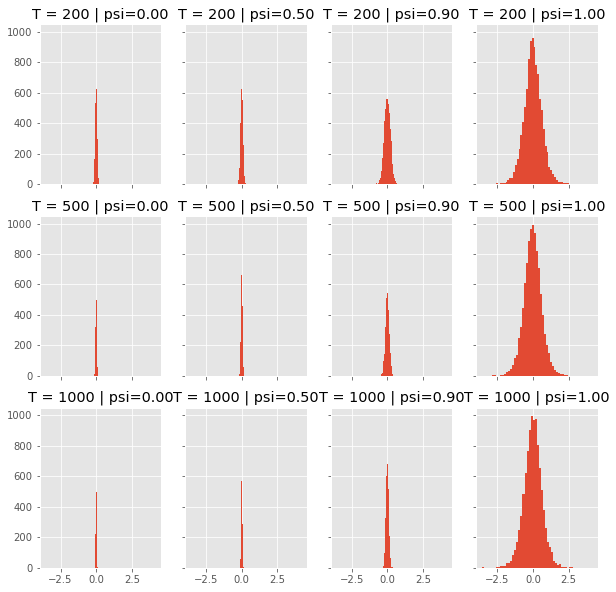

In [27]:
fig, ax = plt.subplots(3,4, 
                       sharex=True, sharey=True,
                       figsize=(10,10))


for i, t in enumerate(T):
    for j, p in enumerate(phi):
        ax[i][j].hist(betas[(t, p)],bins=50)
        ax[i][j].set_title('T = %d | psi=%.2f' %(t,p))

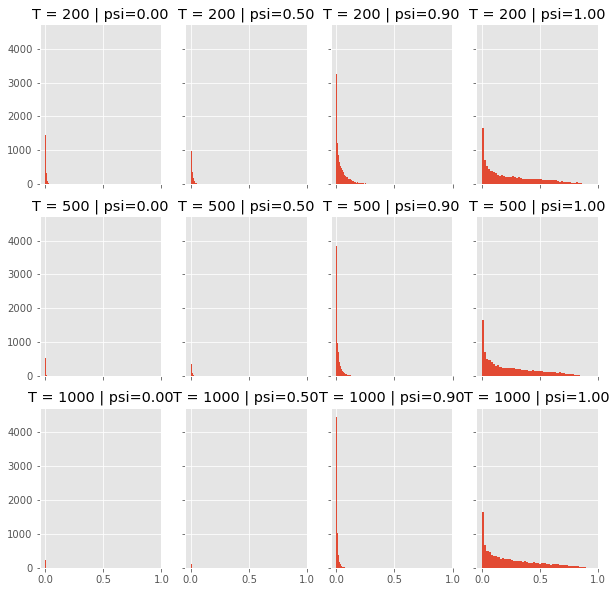

In [28]:
fig, ax = plt.subplots(3,4, 
                       sharex=True, sharey=True,
                       figsize=(10,10))


for i, t in enumerate(T):
    for j, p in enumerate(phi):
        ax[i][j].hist(r2s[(t, p)],bins=50)
        ax[i][j].set_title('T = %d | psi=%.2f' %(t,p))

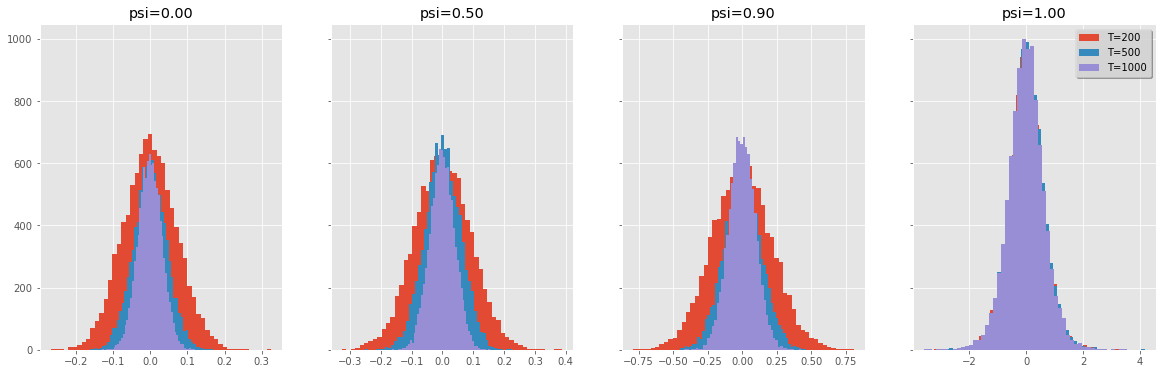

In [29]:
fig, ax = plt.subplots(1,4, 
                       sharey=True,
                       figsize=(20,6))

for j, p in enumerate(phi):   
    ax[j].set_title('psi=%.2f' %(p))
    for i, t in enumerate(T):
        ax[j].hist(betas[(t, p)],bins=50, label='T=%d' %t)
plt.legend(shadow=True)

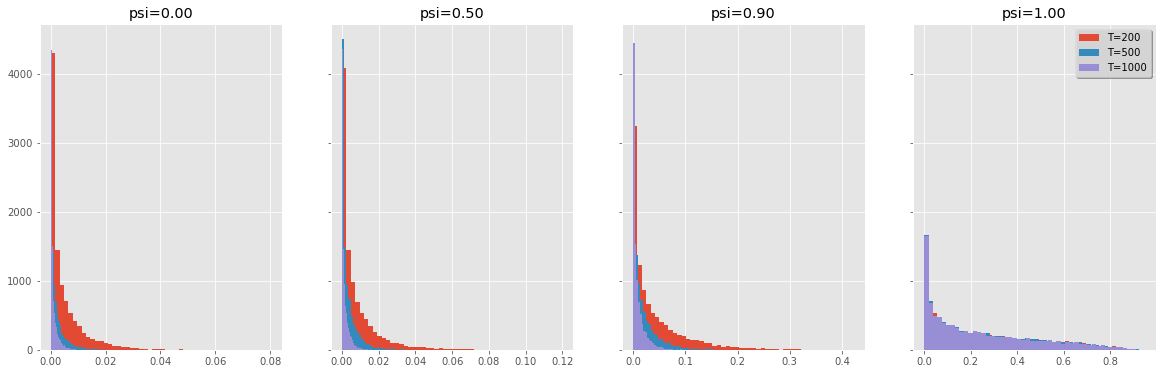

In [30]:
fig, ax = plt.subplots(1,4, 
                       sharey=True,
                       figsize=(20,6))

for j, p in enumerate(phi):   
    ax[j].set_title('psi=%.2f' %(p))
    for i, t in enumerate(T):
        ax[j].hist(r2s[(t, p)],bins=50, label='T=%d' %t)
plt.legend(shadow=True)